In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# use Nvidia GPU, if available
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(dev)

cpu


### Loading Data

In [3]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [4]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [5]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### inspecting training data

`training_data` in format `(image_tensor, label)` with `image_tensor` being of shape (1, 28, 28)

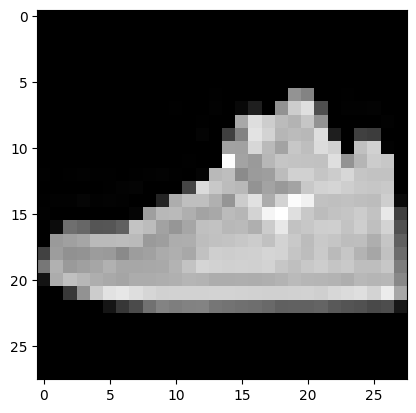

In [6]:
image, label = training_data[1]
plt.imshow(image.squeeze().numpy(), cmap='gray')

### Exercise 2: Fixed MLP with Increasing Training Dataset

- Create a MLP with **one hidden layer** with **200 units** for Fashion MNIST classification. Use **ReLU activation**.

- Use a **random fraction** (shuffle=True) of the training set (split above) to perform the training. *Always use the same validation set*.
- Use **SGD** and **cross-entropy loss** and **suitable learning rate**.
- Start with a **single small batch** for training (batch size 8) and **make sure that you can overfit**, i.e. bring the training accuracy to 100%.
- **Double Descent:** Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [12]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input

def mlp(units = [28*28, 200, 10]):
    """
    Arguments:
        units: [input, hidden, output]
        
    Return:
        model: instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """

    # YOUR CODE HERE #
    model = torch.nn.Sequential(
        # input nodes
        torch.nn.Flatten(),                  # Input nodes (28x28 --> 784 (1D))
        torch.nn.Linear(units[0], units[1]), # Hidden layer
        torch.nn.ReLU(),
        torch.nn.Linear(units[1], units[2])  # Output nodes
    )
    
    return model

In [13]:
# create an instance and show its summary

model = mlp()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


#### Training Loop 

In [43]:
training_loader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=8, shuffle=True)

len(training_loader.dataset)



50000

In [52]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):
    """
    Performs the training of a model with given 
        learning rate       (lr), 
        number of epochs    (nepochs), 
        batchsize           (nbatch),
        training and validation data

    Suitable data loaders are instantiated for the training and validation datasets.
    Keep track of cost and accuracy (per epoch) for both training and validation set.
    """
    # metrics to update once per epoch
    cost_hist_train = [] # training
    acc_hist_train = []

    cost_hist_val = [] # validation
    acc_hist_val = []

    # YOUR CODE HERE #

    # Set up cost function and optimizer that operates on it 
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Set up data loaders -> iterables to draw samples from
    # (done inside this function to draw new random set every time function is called)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True) # (?) "always use same validation data" 
    
    
    # train: make prediction, calculate loss (for tracking), step downhill in parameter-space of cost function 
    for epoch in range(nepochs):
        # Training -----------------------------------------------------------------------------
        agg_loss_train = 0.0    # for cost calc at end of epoch
        agg_correct_train = 0.0 # for accuracy calc at end of epoch
        for batch, (X, Y) in enumerate(training_loader):
            # Actual training
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad() # reset gradient accumulation
            loss.backward() # compute gradient in back-prop
            optimizer.step()

            # Track loss and accuracy across batch
            agg_loss_train += loss.item()
            agg_correct_train += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost_hist_train.append(agg_loss_train / len(training_loader.dataset))
        acc_hist_train.append(agg_correct_train / len(training_loader.dataset))

        # Validation ----------------------------------------------------------------------------
        agg_loss_val = 0.0
        agg_correct_val = 0.0
        with torch.no_grad(): # won't be doing GD on these tensors, so turn off automatic tracking
            for X, Y in validation_loader:
                pred = model(X) # pred.shape = (nbatch, 10)

                # Track loss and accuracy across batch
                agg_loss_val += cost_ce(pred, Y).item()
                agg_correct_val += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost_hist_val.append(agg_loss_val / len(validation_loader.dataset))
        acc_hist_val.append(agg_correct_val / len(validation_loader.dataset))
        


    return cost_hist_train, cost_hist_val, acc_hist_train, acc_hist_val

#### First Training

Run a first training with **only one small training batch** (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

--> Doing the same thing as actual training, but with smaller training set. Lower quality predictions, but qualitative characteristics of a correctly working training algorithm should be evident in learning curves

This is something you can always do when training a model.

In [ ]:
nbatch = 32
nbatches = 1  # test run
nepochs = 100
lr = 0.1

trainsize = nbatches*nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

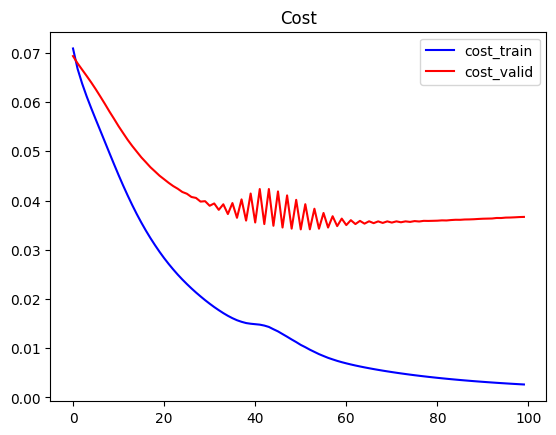

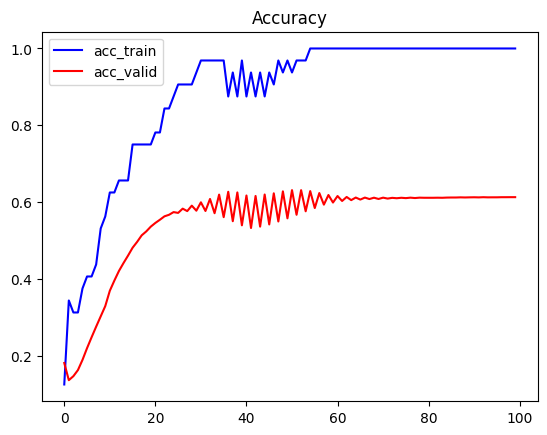

In [57]:
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.legend()


#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

#### Comments: YOUR comments

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

In [ ]:
# YOUR CODE HERE #
# several iterations with the code snippets of the form:

nbatch = 64
nepochs = 
lr = 

model = 

cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")



#### Comments: YOUR findings.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [57]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """

    # YOUR CODE HERE #

    

In [58]:
model = mlp_dropout([28*28,200,10])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
           Dropout-4                  [-1, 200]               0
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

In [ ]:

# YOUR CODE HERE #

